In [1]:
import os
import numpy as np
#from scipy import signal
import matplotlib.pyplot as plt

In [2]:
#make model to Xie (2021)
Z1=500; Z2=1000; X=1500
vmin=2500; vmax=3000

h=20  #500/20=25
nz1=26; nz2=50; nz=nz1+nz2; nx=X//h+1
print(nz,nx)
ntr=76

nsnap=51; nzsnap=124; nxsnap=124

#5h=lambda=vmin/fmax
fmax=vmin/(5*h) #
fpeak=fmax/2.5  #10 Hz

#on time
dt=0.002  #=half of CFL
nt=750

76 76


In [3]:
def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def read_snap(filename,n=(nsnap,nxsnap,nzsnap),i=26):
    tmp=np.fromfile(filename,dtype='float32').reshape(n).T
    return tmp[:,:,i]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],extent=extent,cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def run(app='../../exe/RTM',setup='setup',np=1,nthreads=8,out=None):
    '''
    run(app,setup,np=1,nthreads=8)
    run in a bash env
    ----------------------------
    app      : application/executable to run
    setup    : setup file
    np       : number of MPI processors (default=1)
    nthreads : number of OpenMP threads (default=8)
    
    Caveat: np*nthreads should not exceed total number of CPU cores
    otherwise the running will be very slow
    '''
    
    !echo 'ulimit -s unlimited' > run.sh
    str=f"export OMP_NUM_THREADS={nthreads}"
    !echo $str >> run.sh
    str=f"{app} {setup}"
    !echo $str >> run.sh
    !chmod +x run.sh
    if out==None:
        !./run.sh
    else:
        !./run.sh > {out}
    

def poynting_dotp_gradp(p,p_prev,p_next):
    dotp=(p_next+p_prev-2.*p)/dt**2
    dpdz=np.gradient(p,1./h,axis=0)
    dpdx=np.gradient(p,1./h,axis=1)
    return (dotp*dpdz, dotp*dpdx)
    
def poynting_p_dotp_gradp(p,p_prev,p_next):
    tmp=poynting_dotp_gradp(p,p_prev,p_next)
    return (p*tmp[0], p*tmp[1])

def poynting_p_v(p,vz,vx):
    return (-p*vz, -p*vx)

def gradphi(v,u):
    ph=np.arctan2(v,u)
    dphdz=np.arcsin(np.sin(np.gradient(ph,axis=0)))/h
    dphdx=np.arcsin(np.sin(np.gradient(ph,axis=1)))/h
    return (dphdz,dphdx)

(76, 76)


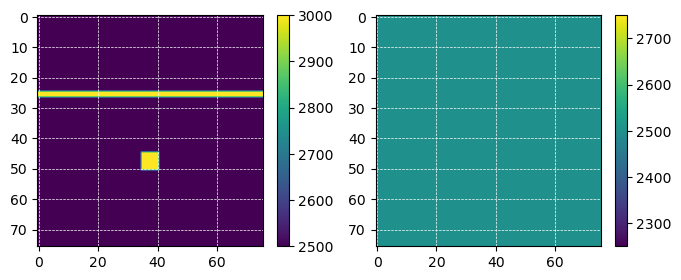

In [4]:
#make model
vp=np.zeros((nz,nx)); print(vp.shape)
vp[:,:]=vmin
vp[nz1-1:nz1+1,:]=vmax
vp[45:51,35:41]=vmax
vp.astype('float32').T.tofile('true')

vp[:nz1,:]=vmin; vp[nz1:,:]=vmin
vp.astype('float32').T.tofile('homo')

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(read('homo'))


In [5]:
!cat setup_default

MODEL_SIZE              '76 76 1'
MODEL_SPACING           '20 20 1'
FILE_MODEL              'true'
MODEL_ATTRIBUTES         vp
FILE_TOPO               'topo'

IS_FREESURFACE          F

ACQUI_GEOMETRY          spread
FS                      '20 760 0'
FR                      '20   0 0'
DR                      '0   20  0'
NR                      76

SCOMP                   p
RCOMP                   p #'p vz'

NT               750
DT               0.002


FPEAK            10
WAVELET_TYPE        'ricker'
T0			0.15
UPDATE_WAVELET		'no'
RDT			0


SNAPSHOT     'p'
#SNAPSHOT     'p poynz poynx'
#NSNAPSHOT    50


## for RTM ##
FILE_DATA_PREFIX    'results_obs/Ru_Shot'

JOB           imaging

IF_USE_CHECKPOINT   F



## Obs

In [6]:
!cp setup_default setup
!echo "DIR_OUT     results_obs" >> setup
run(app='../../exe/fwd_AC_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 646912 Aug 30 10:41 ../../exe/fwd_AC_FDSG_O4_
 Git Commit: 27d8e8c
 Git Branch: Poynting
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/02/2023
System time: 14:20:12
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs
 Output directory:results_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606(for 2D) or 0.49

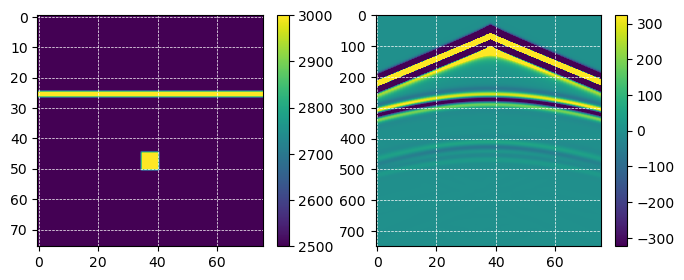

In [7]:
## plot
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(read_su('results_obs/Ru_Shot0001.su'),perc=90)

## all traces

### RTM

In [8]:
!cp setup_default setup
!echo "FILE_MODEL   homo" >>setup
!echo "DIR_OUT     results_rtm" >> setup
run(app='../../exe/rtm_AC_FDSG_O4')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 2439288 Sep  2 12:40 ../../exe/rtm_AC_FDSG_O4
 Git Commit: 2ca4544
 Git Branch: ellipse_hyperbola
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/02/2023
System time: 14:20:14
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTM        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_rtm
 Output directory:results_rtm/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606(for 2D

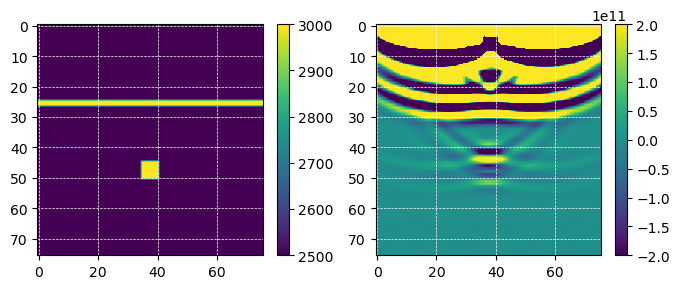

In [9]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(read('results_rtm/correlate_image'),clip=(-2e11,2e11))

## symm 2 traces

### RTM ellipse

In [10]:
!cp setup_default setup
!suwind < results_obs/Ru_Shot0001.su key=tracl min=19 max=19 > obs_Shot0001_1.su
!suwind < results_obs/Ru_Shot0001.su key=tracl min=57 max=57 > obs_Shot0001_2.su
!cat obs_Shot0001_1.su obs_Shot0001_2.su > obs_Shot0001.su
!echo "FILE_MODEL   homo" >>setup
!echo "FILE_DATA_PREFIX    obs_Shot" >>setup
!echo "DIR_OUT     results_2tr_rtm" >> setup
run(app='../../exe/rtm_AC_FDSG_O4')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 2439288 Sep  2 12:40 ../../exe/rtm_AC_FDSG_O4
 Git Commit: 2ca4544
 Git Branch: ellipse_hyperbola
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/02/2023
System time: 14:20:18
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTM        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_2tr_rtm
 Output directory:results_2tr_rtm/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.60

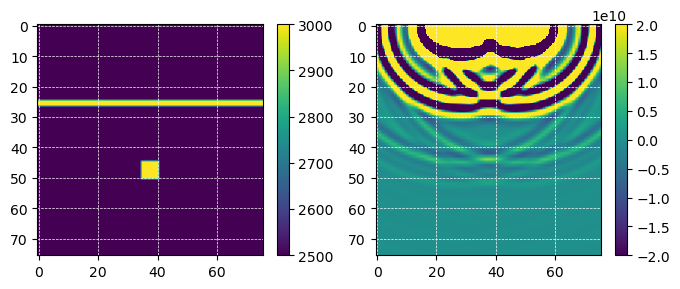

In [11]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(read('results_2tr_rtm/correlate_image'),clip=(-2e10,2e10))

### RTM hyperbola

In [12]:
!cp setup_default setup
!cp obs_Shot0001_1.su obs_Shot0001.su
!echo "FILE_MODEL   homo" >>setup
!echo "FILE_DATA_PREFIX    obs_Shot" >>setup
!ls -l obs_Shot0001.su obs_Shot0001_2.su
!echo "DIR_OUT     results_2tr_rtmhyperbola" >> setup
run(app='../../exe/rtmhyperbola_AC_FDSG_O4')

-rw-rw-r-- 1 joey joey 3240 Sep  2 14:20 obs_Shot0001_2.su
-rw-rw-r-- 1 joey joey 3240 Sep  2 14:20 obs_Shot0001.su
 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 2437648 Sep  2 14:16 ../../exe/rtmhyperbola_AC_FDSG_O4
 Git Commit: 2ca4544
 Git Branch: ellipse_hyperbola
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/02/2023
System time: 14:20:21
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTMhyperbola
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_2tr_rtmhyperbola
 Output directory:results_2tr_rtmhyperbola/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vire

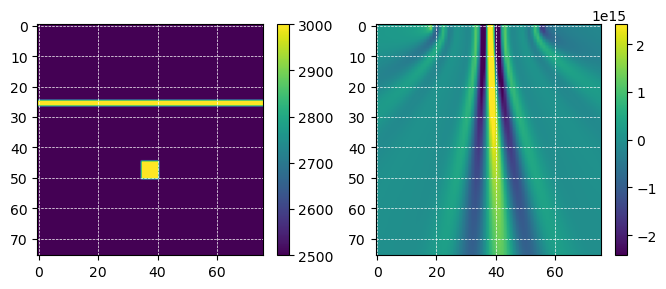

In [13]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(read('results_2tr_rtmhyperbola/correlate_image'),perc=98)

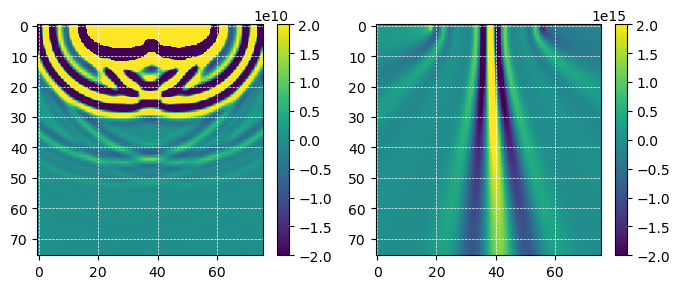

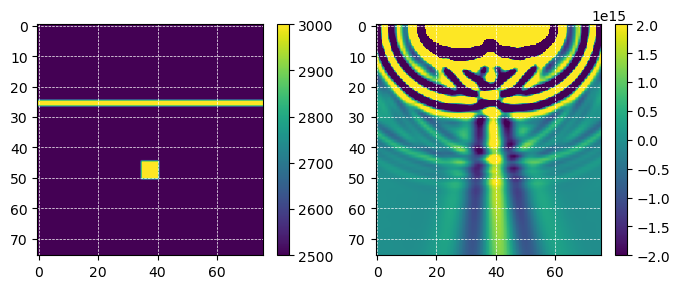

In [14]:
ellipse=read('results_2tr_rtm/correlate_image')
hyperbola=read('results_2tr_rtmhyperbola/correlate_image')
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(ellipse,clip=(-2e10,2e10))
plt.subplot(1,2,2); imshow(hyperbola,clip=(-2e15,2e15))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(ellipse*1e5+hyperbola,clip=(-2e15,2e15))

## asymm 2 traces case 1

### RTM ellipse

In [15]:
!cp setup_default setup
!suwind < results_obs/Ru_Shot0001.su key=tracl min=38 max=38 > obs_Shot0001_1.su
!suwind < results_obs/Ru_Shot0001.su key=tracl min=76 max=76 > obs_Shot0001_2.su
!cat obs_Shot0001_1.su obs_Shot0001_2.su > obs_Shot0001.su
!echo "FILE_MODEL   homo" >>setup
!echo "FILE_DATA_PREFIX    obs_Shot" >>setup
!echo "DIR_OUT     results_2tr_rtm" >> setup
run(app='../../exe/rtm_AC_FDSG_O4')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 2439288 Sep  2 12:40 ../../exe/rtm_AC_FDSG_O4
 Git Commit: 2ca4544
 Git Branch: ellipse_hyperbola
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/02/2023
System time: 14:20:27
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTM        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_2tr_rtm
 Output directory:results_2tr_rtm/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.60

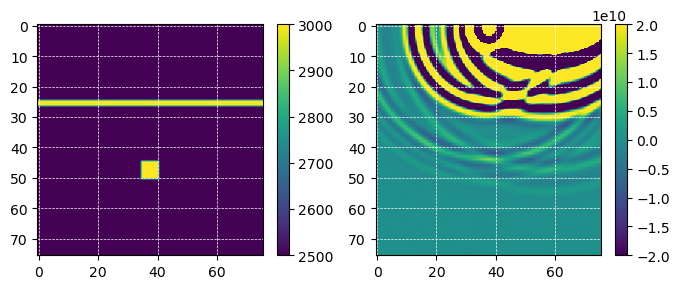

In [16]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(read('results_2tr_rtm/correlate_image'),clip=(-2e10,2e10))

### RTM hyperbola

In [17]:
!cp setup_default setup
!cp obs_Shot0001_1.su obs_Shot0001.su
!echo "FILE_MODEL   homo" >>setup
!echo "FILE_DATA_PREFIX    obs_Shot" >>setup
!ls -l obs_Shot0001.su obs_Shot0001_2.su
!echo "DIR_OUT     results_2tr_rtmhyperbola" >> setup
run(app='../../exe/rtmhyperbola_AC_FDSG_O4')

-rw-rw-r-- 1 joey joey 3240 Sep  2 14:20 obs_Shot0001_2.su
-rw-rw-r-- 1 joey joey 3240 Sep  2 14:20 obs_Shot0001.su
 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 2437648 Sep  2 14:16 ../../exe/rtmhyperbola_AC_FDSG_O4
 Git Commit: 2ca4544
 Git Branch: ellipse_hyperbola
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/02/2023
System time: 14:20:30
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTMhyperbola
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_2tr_rtmhyperbola
 Output directory:results_2tr_rtmhyperbola/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vire

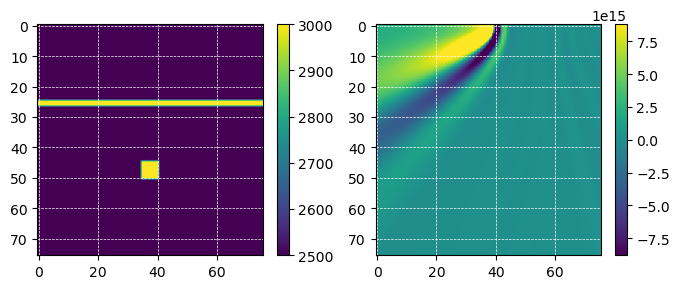

In [18]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(read('results_2tr_rtmhyperbola/correlate_image'),perc=98)

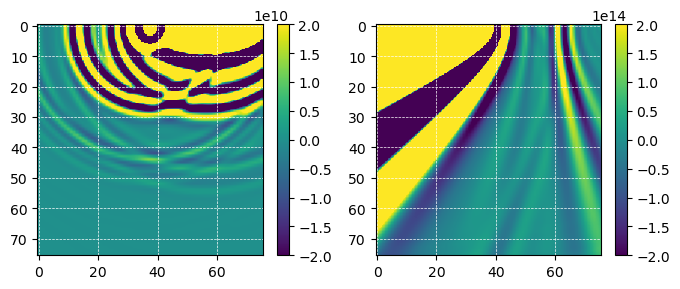

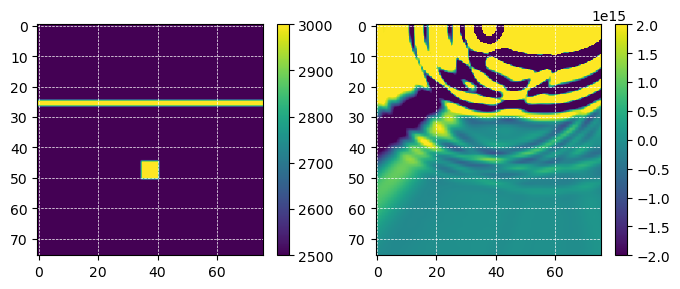

In [19]:
ellipse=read('results_2tr_rtm/correlate_image')
hyperbola=read('results_2tr_rtmhyperbola/correlate_image')
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(ellipse,clip=(-2e10,2e10))
plt.subplot(1,2,2); imshow(hyperbola,clip=(-2e14,2e14))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(ellipse*1e5+hyperbola,clip=(-2e15,2e15))

## asymm 2 traces Case 2

### RTM ellipse

In [20]:
!cp setup_default setup
!suwind < results_obs/Ru_Shot0001.su key=tracl min=19 max=19 > obs_Shot0001_1.su
!suwind < results_obs/Ru_Shot0001.su key=tracl min=76 max=76 > obs_Shot0001_2.su
!cat obs_Shot0001_1.su obs_Shot0001_2.su > obs_Shot0001.su
!echo "FILE_MODEL   homo" >>setup
!echo "FILE_DATA_PREFIX    obs_Shot" >>setup
!echo "DIR_OUT     results_2tr_rtm" >> setup
run(app='../../exe/rtm_AC_FDSG_O4')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 2439288 Sep  2 12:40 ../../exe/rtm_AC_FDSG_O4
 Git Commit: 2ca4544
 Git Branch: ellipse_hyperbola
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/02/2023
System time: 14:20:36
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTM        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_2tr_rtm
 Output directory:results_2tr_rtm/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.60

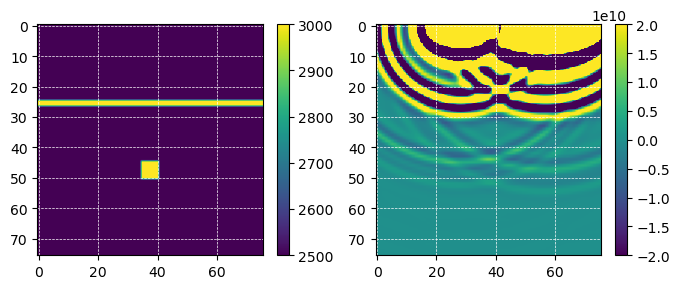

In [21]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(read('results_2tr_rtm/correlate_image'),clip=(-2e10,2e10))

### RTM hyperbola

In [22]:
!cp setup_default setup
!cp obs_Shot0001_1.su obs_Shot0001.su
!echo "FILE_MODEL   homo" >>setup
!echo "FILE_DATA_PREFIX    obs_Shot" >>setup
!ls -l obs_Shot0001.su obs_Shot0001_2.su
!echo "DIR_OUT     results_2tr_rtmhyperbola" >> setup
run(app='../../exe/rtmhyperbola_AC_FDSG_O4')

-rw-rw-r-- 1 joey joey 3240 Sep  2 14:20 obs_Shot0001_2.su
-rw-rw-r-- 1 joey joey 3240 Sep  2 14:20 obs_Shot0001.su
 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_Imaging
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 2437648 Sep  2 14:16 ../../exe/rtmhyperbola_AC_FDSG_O4
 Git Commit: 2ca4544
 Git Branch: ellipse_hyperbola
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 09/02/2023
System time: 14:20:39
System timezone: +03:00
                        
       WELCOME TO SeisJIMU RTMhyperbola
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_2tr_rtmhyperbola
 Output directory:results_2tr_rtmhyperbola/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D/3D ACoustic propagation
1st-order Velocity-Stress formulation
Vire

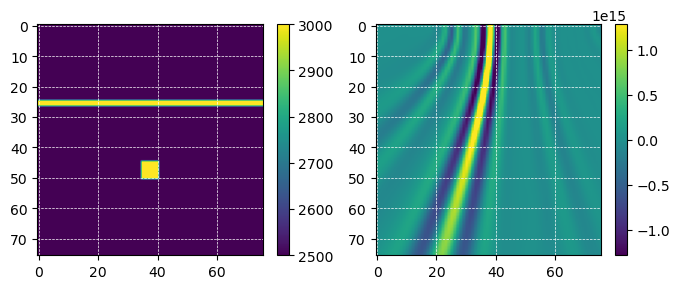

In [23]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(read('results_2tr_rtmhyperbola/correlate_image'),perc=98)

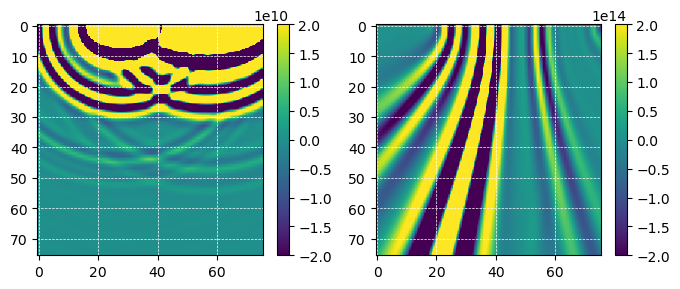

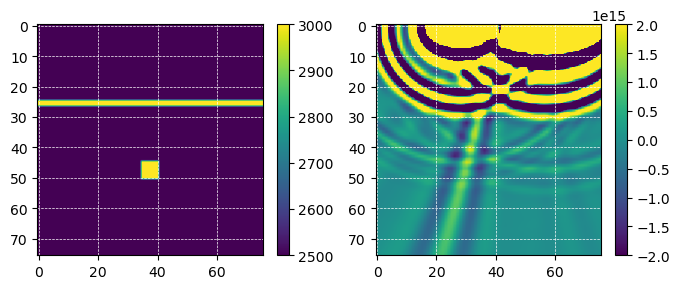

In [27]:
ellipse=read('results_2tr_rtm/correlate_image')
hyperbola=read('results_2tr_rtmhyperbola/correlate_image')
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(ellipse,clip=(-2e10,2e10))
plt.subplot(1,2,2); imshow(hyperbola,clip=(-2e14,2e14))

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('true'))
plt.subplot(1,2,2); imshow(ellipse*1e5+hyperbola,clip=(-2e15,2e15))

We have more definitions on the vertical bnd of the box,
in RTM ellipse+hyperbola than RTM ellipse only